In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [2]:
data=pl.read_csv("CarPrice_Assignment.csv").drop(["car_ID","symboling","CarName"])
data.head()

fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
str,str,str,str,str,str,f64,f64,f64,f64,i64,str,str,i64,str,f64,f64,f64,i64,i64,i64,i64,f64
"""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,13495.0
"""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,16500.0
"""gas""","""std""","""two""","""hatchback""","""rwd""","""front""",94.5,171.2,65.5,52.4,2823,"""ohcv""","""six""",152,"""mpfi""",2.68,3.47,9.0,154,5000,19,26,16500.0
"""gas""","""std""","""four""","""sedan""","""fwd""","""front""",99.8,176.6,66.2,54.3,2337,"""ohc""","""four""",109,"""mpfi""",3.19,3.4,10.0,102,5500,24,30,13950.0
"""gas""","""std""","""four""","""sedan""","""4wd""","""front""",99.4,176.6,66.4,54.3,2824,"""ohc""","""five""",136,"""mpfi""",3.19,3.4,8.0,115,5500,18,22,17450.0


In [3]:
data.shape

(205, 23)

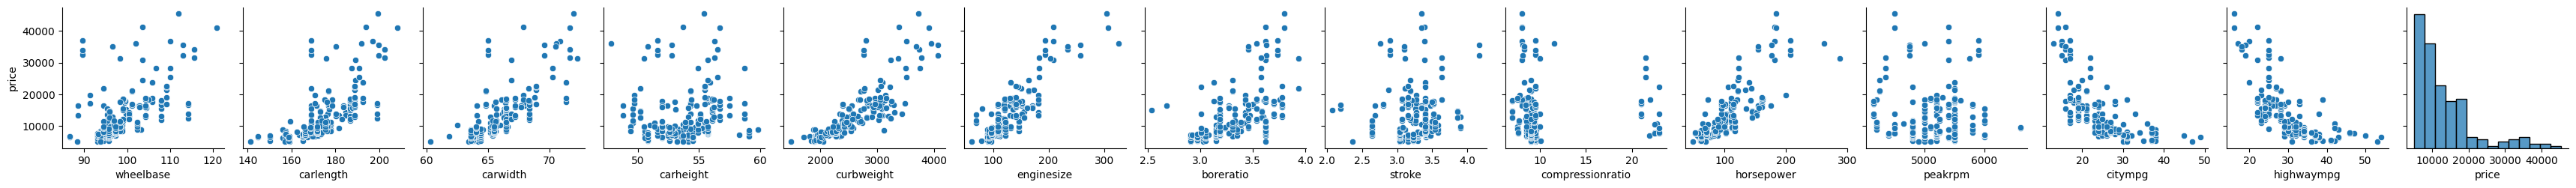

In [4]:
sns.pairplot(data.to_pandas(),y_vars=["price"])

In [5]:
q1=data["price"].quantile(0.25)
q3=data["price"].quantile(0.75)
iqr=q3-q1
q1=q1-0.2*iqr
q3=q3+1.1*iqr
q1,q3

(6045.0, 26089.5)

cutting target column outliers

In [6]:
data=data.filter(data["price"].is_in(np.arange(q1,q3)))
data.shape

(176, 23)

Check for Linearity between independent variables and dependent variable

Missing Values

In [7]:
data.null_count().sum()

fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No missing

In [8]:
cat_cols=[col for col in data.columns if data[col].dtype== pl.String]
num_cols=[col for col in data.columns if data[col].dtype!= pl.String]

Categorical EDA

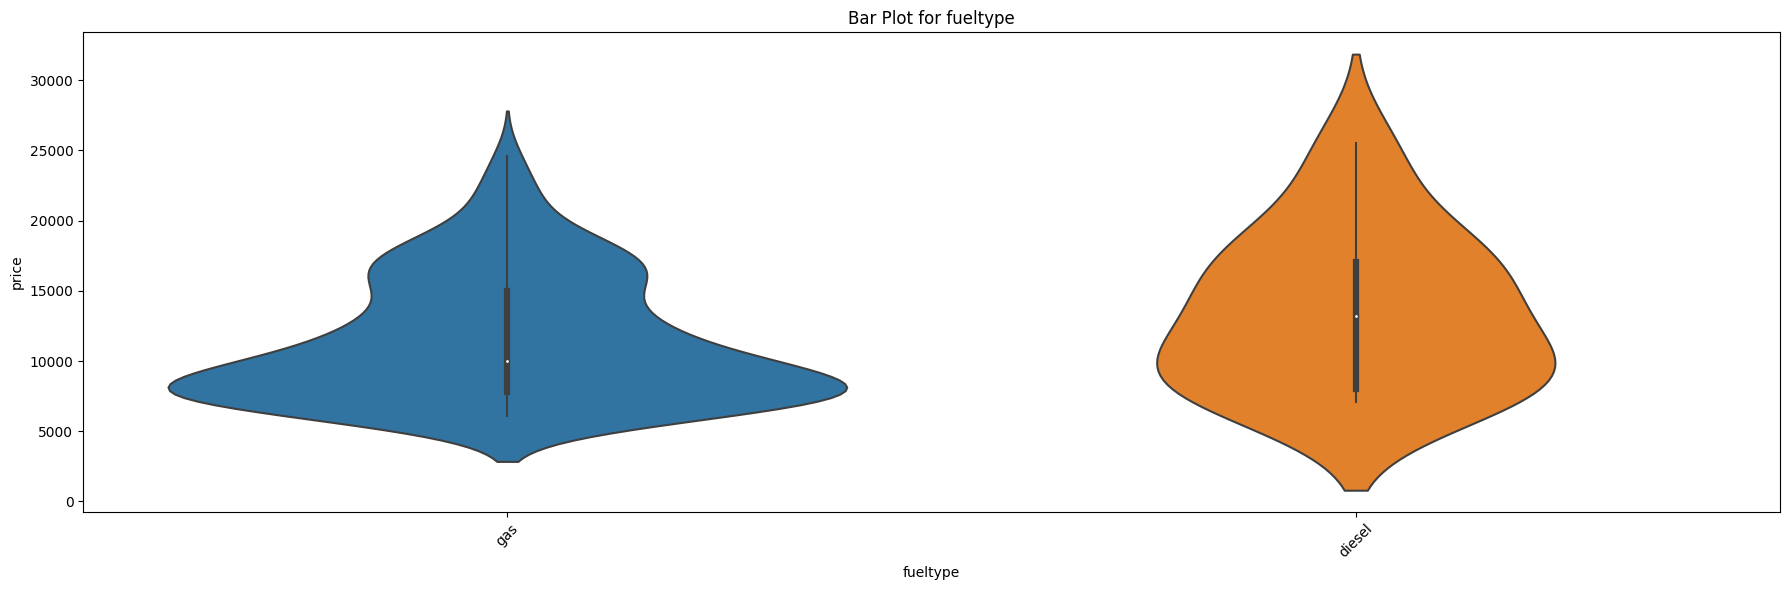

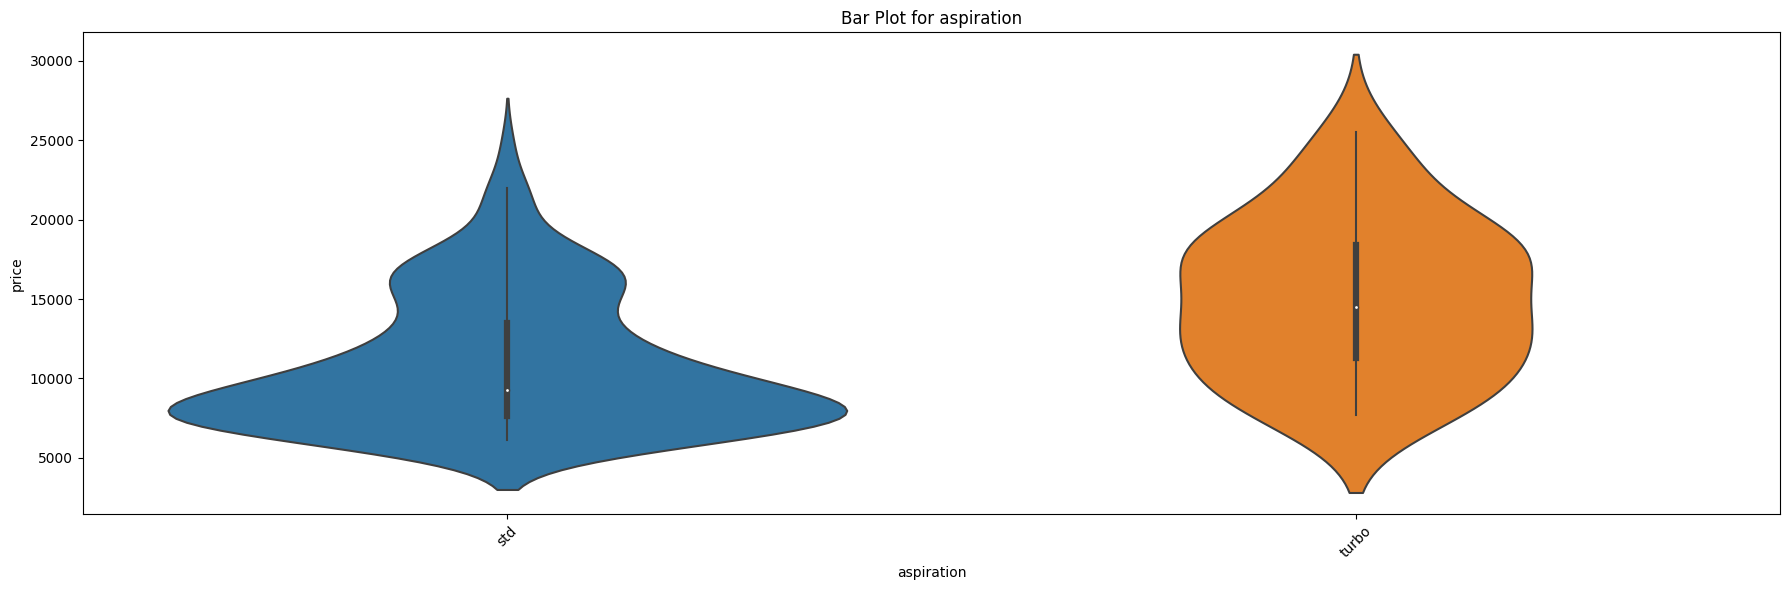

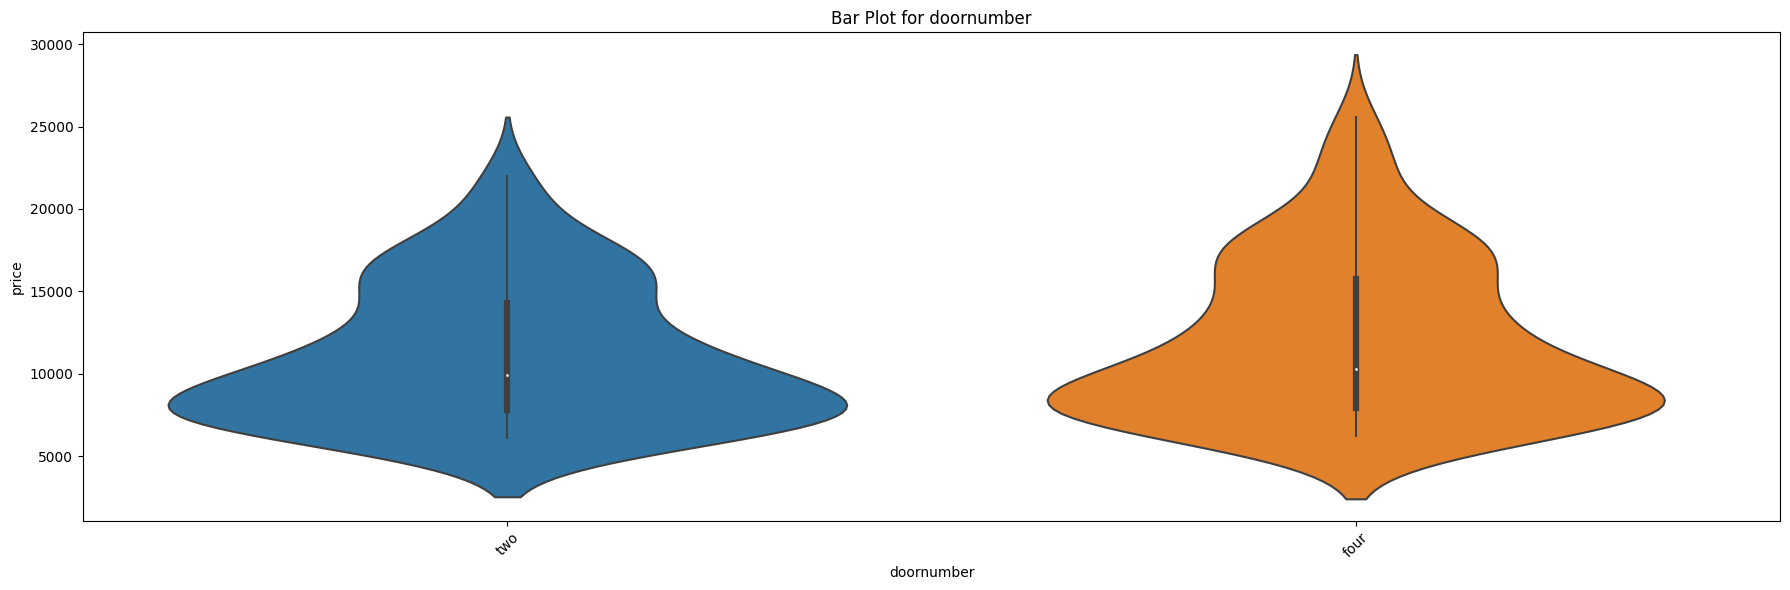

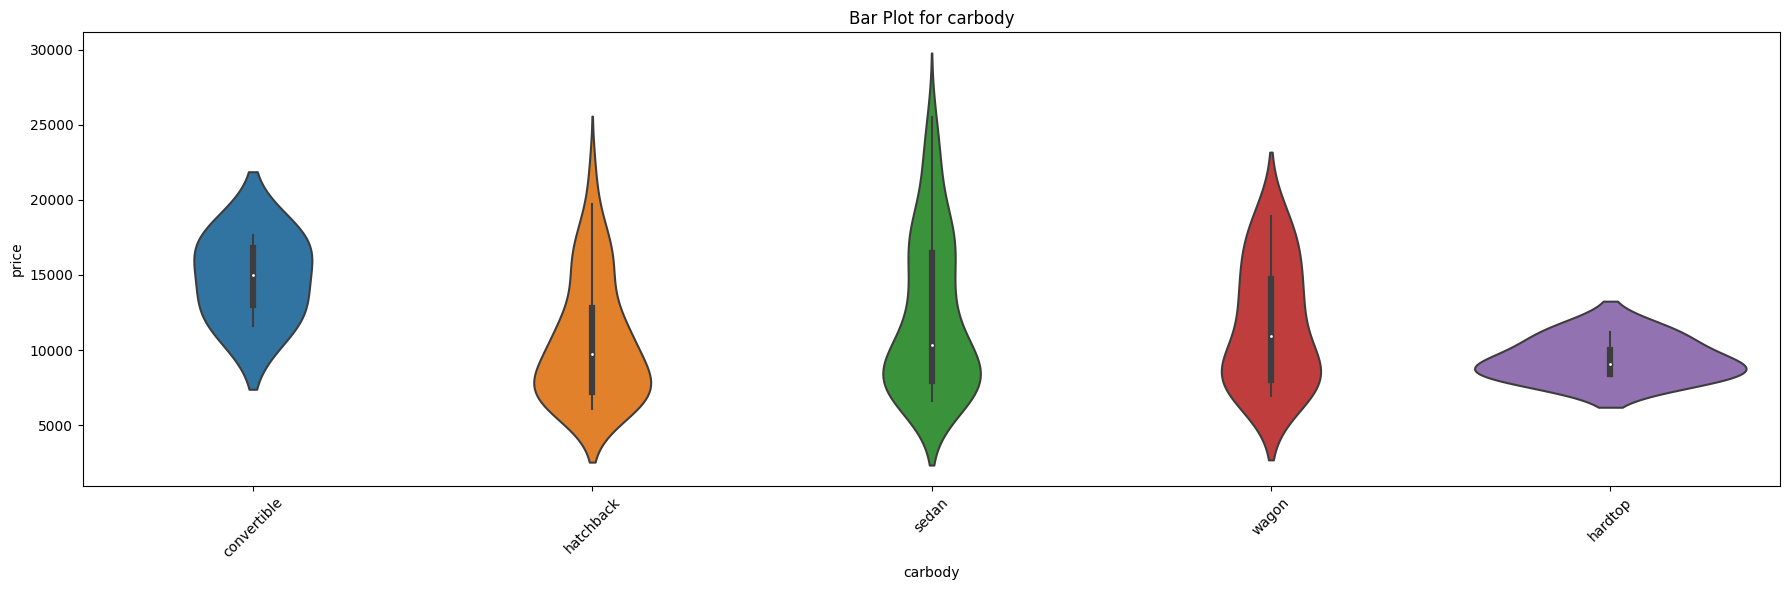

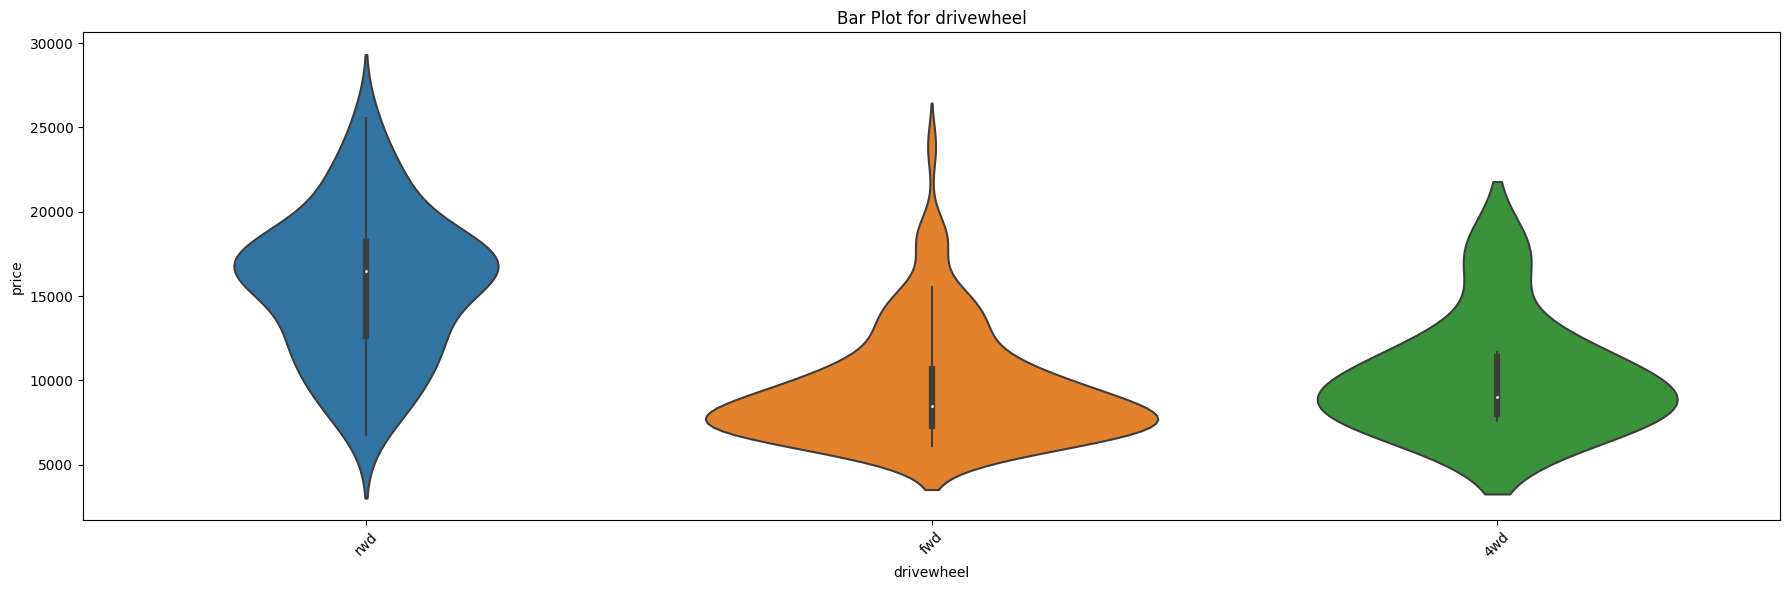

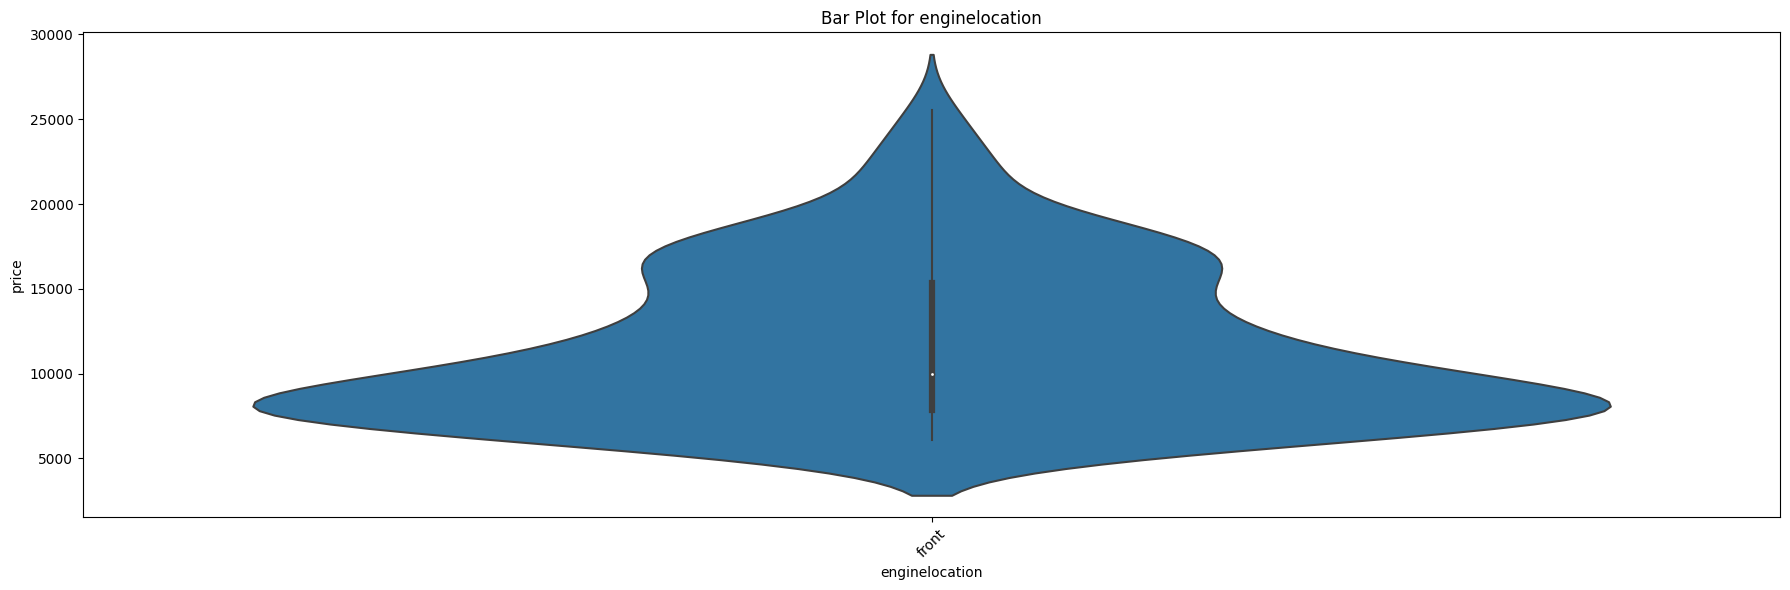

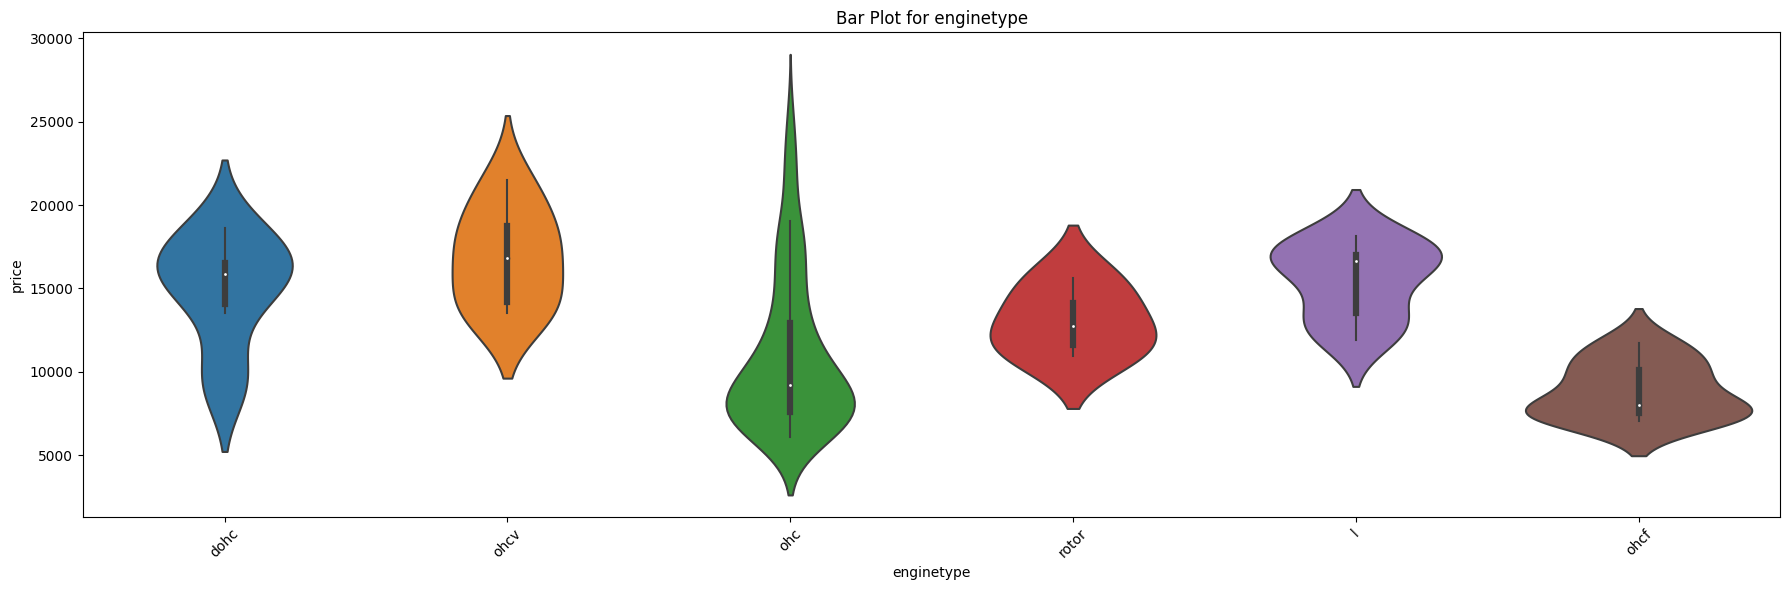

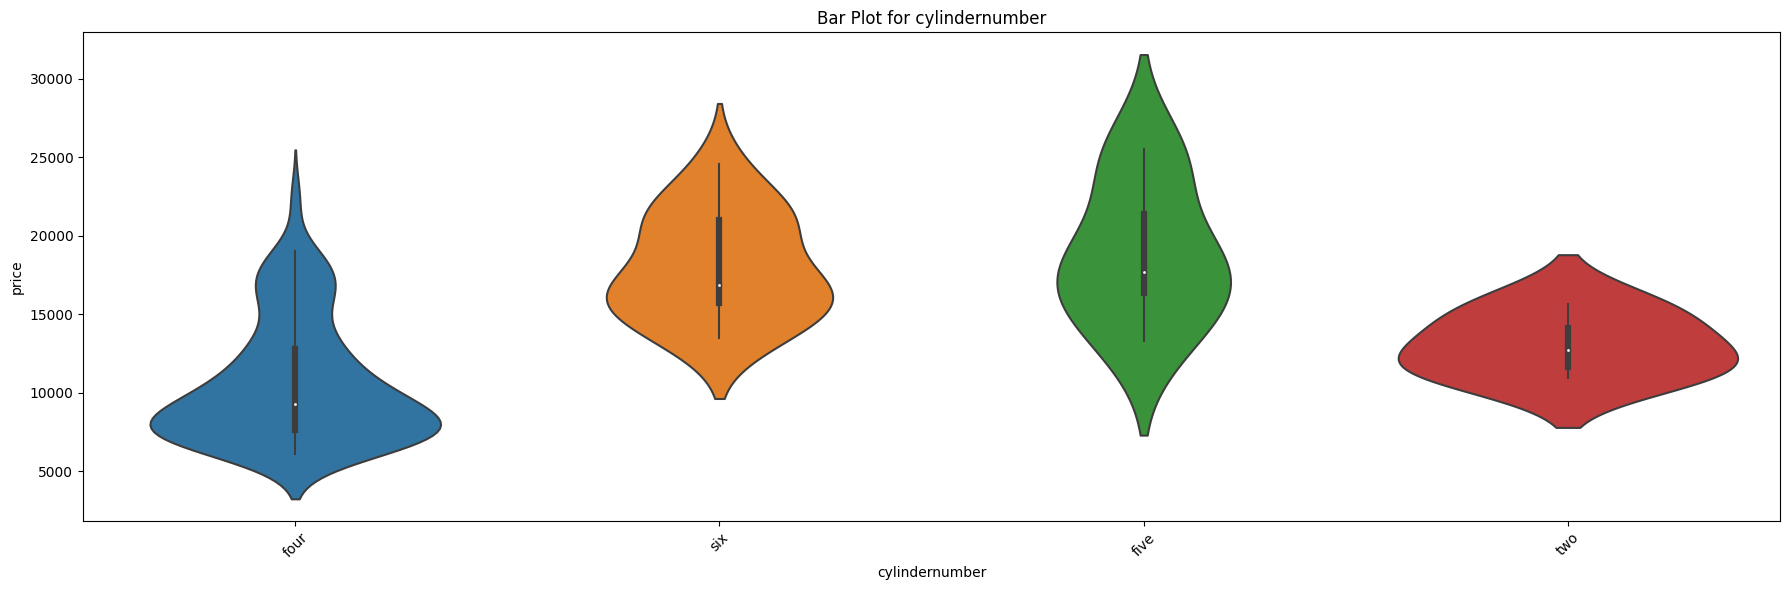

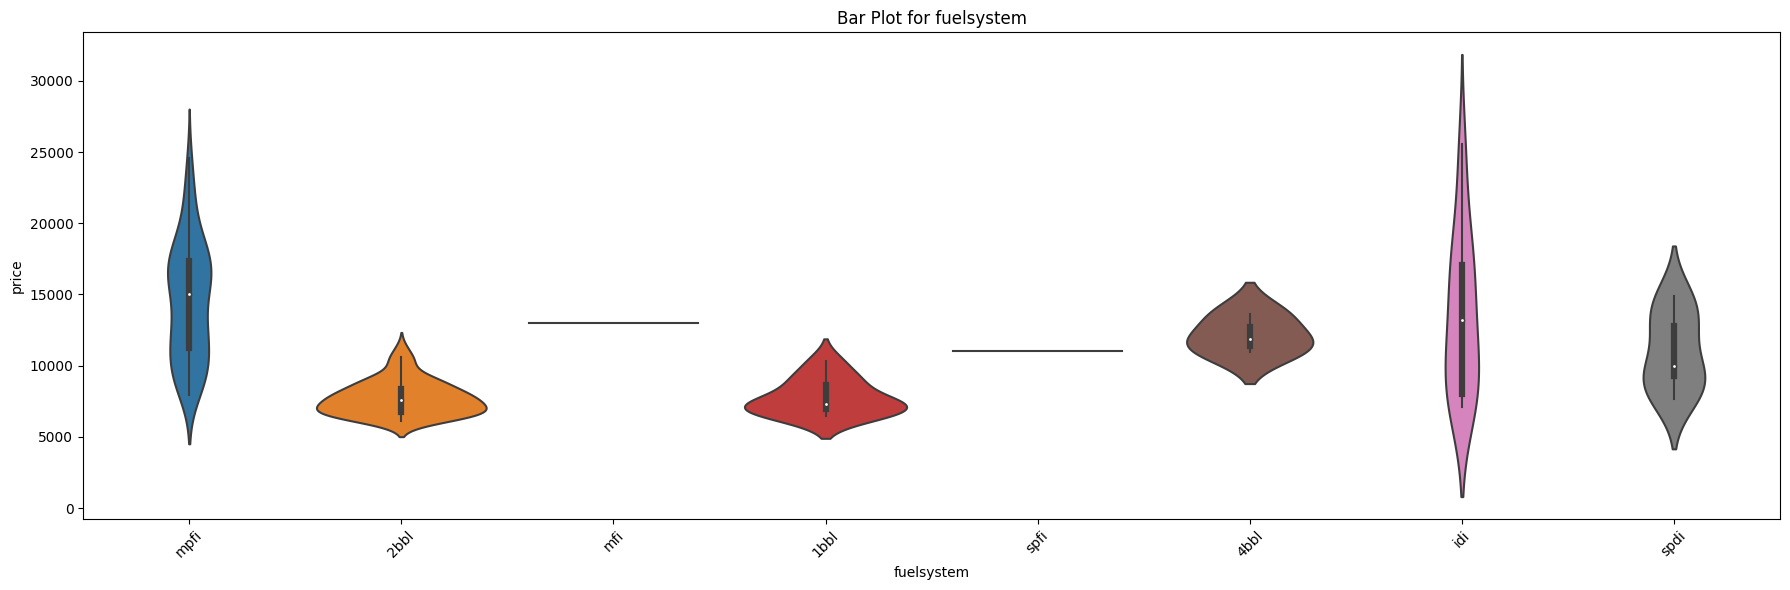

In [9]:
categorical_violin_plot(data.to_pandas(),cat_cols,"price")

In [10]:
data=data.with_columns(data["cylindernumber"].str.replace_many(["two","three","four","five","six","eight","twelve"],["2","3","4","5","6","8","12"]).cast(pl.Int64))
data=data.drop(["carbody","enginetype","fueltype","fuelsystem","aspiration","enginelocation","doornumber","drivewheel"])

In [11]:
cat_cols=[col for  col in cat_cols if col not in ["carbody","enginetype","fueltype","fuelsystem","aspiration","enginelocation","doornumber","drivewheel"]]

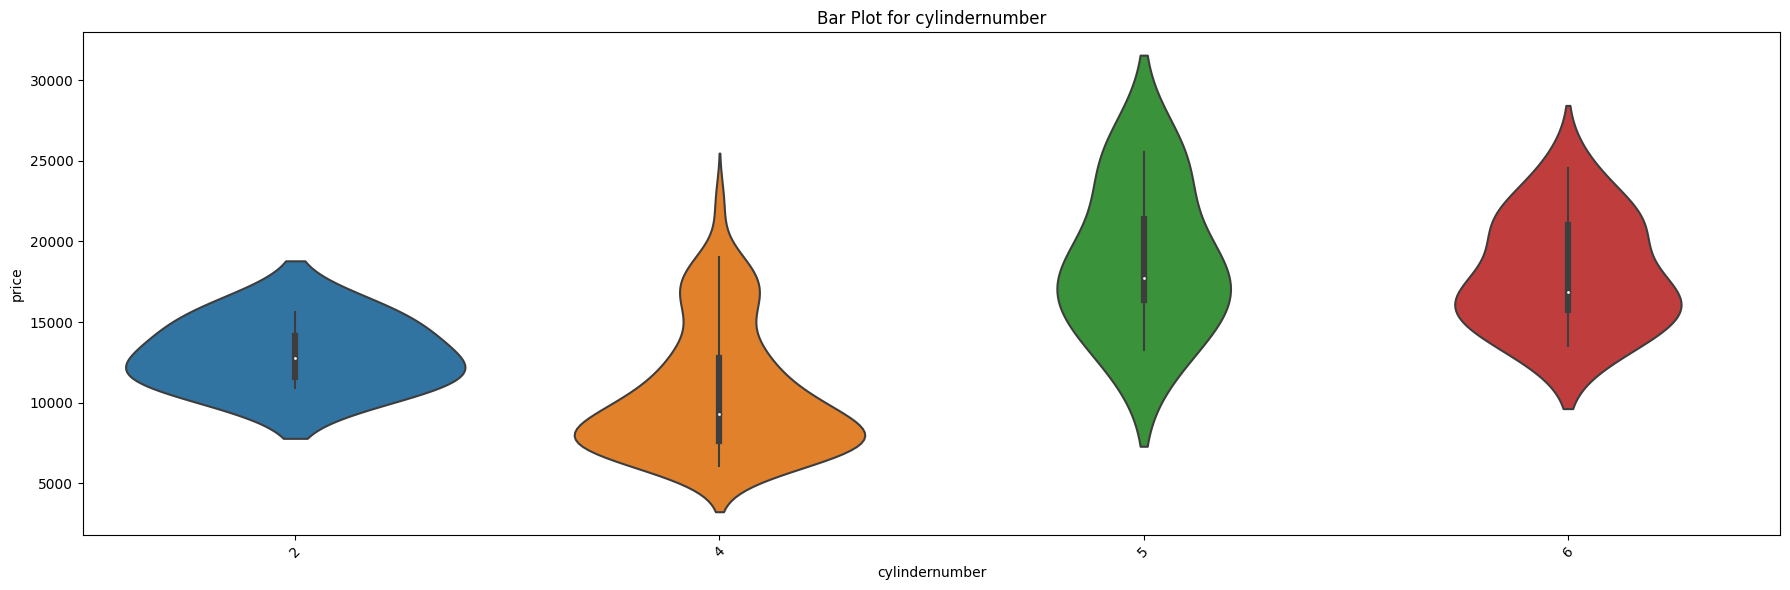

In [12]:
categorical_violin_plot(data.to_pandas(),cat_cols,"price")

Numerical EDA

Univariate analysis

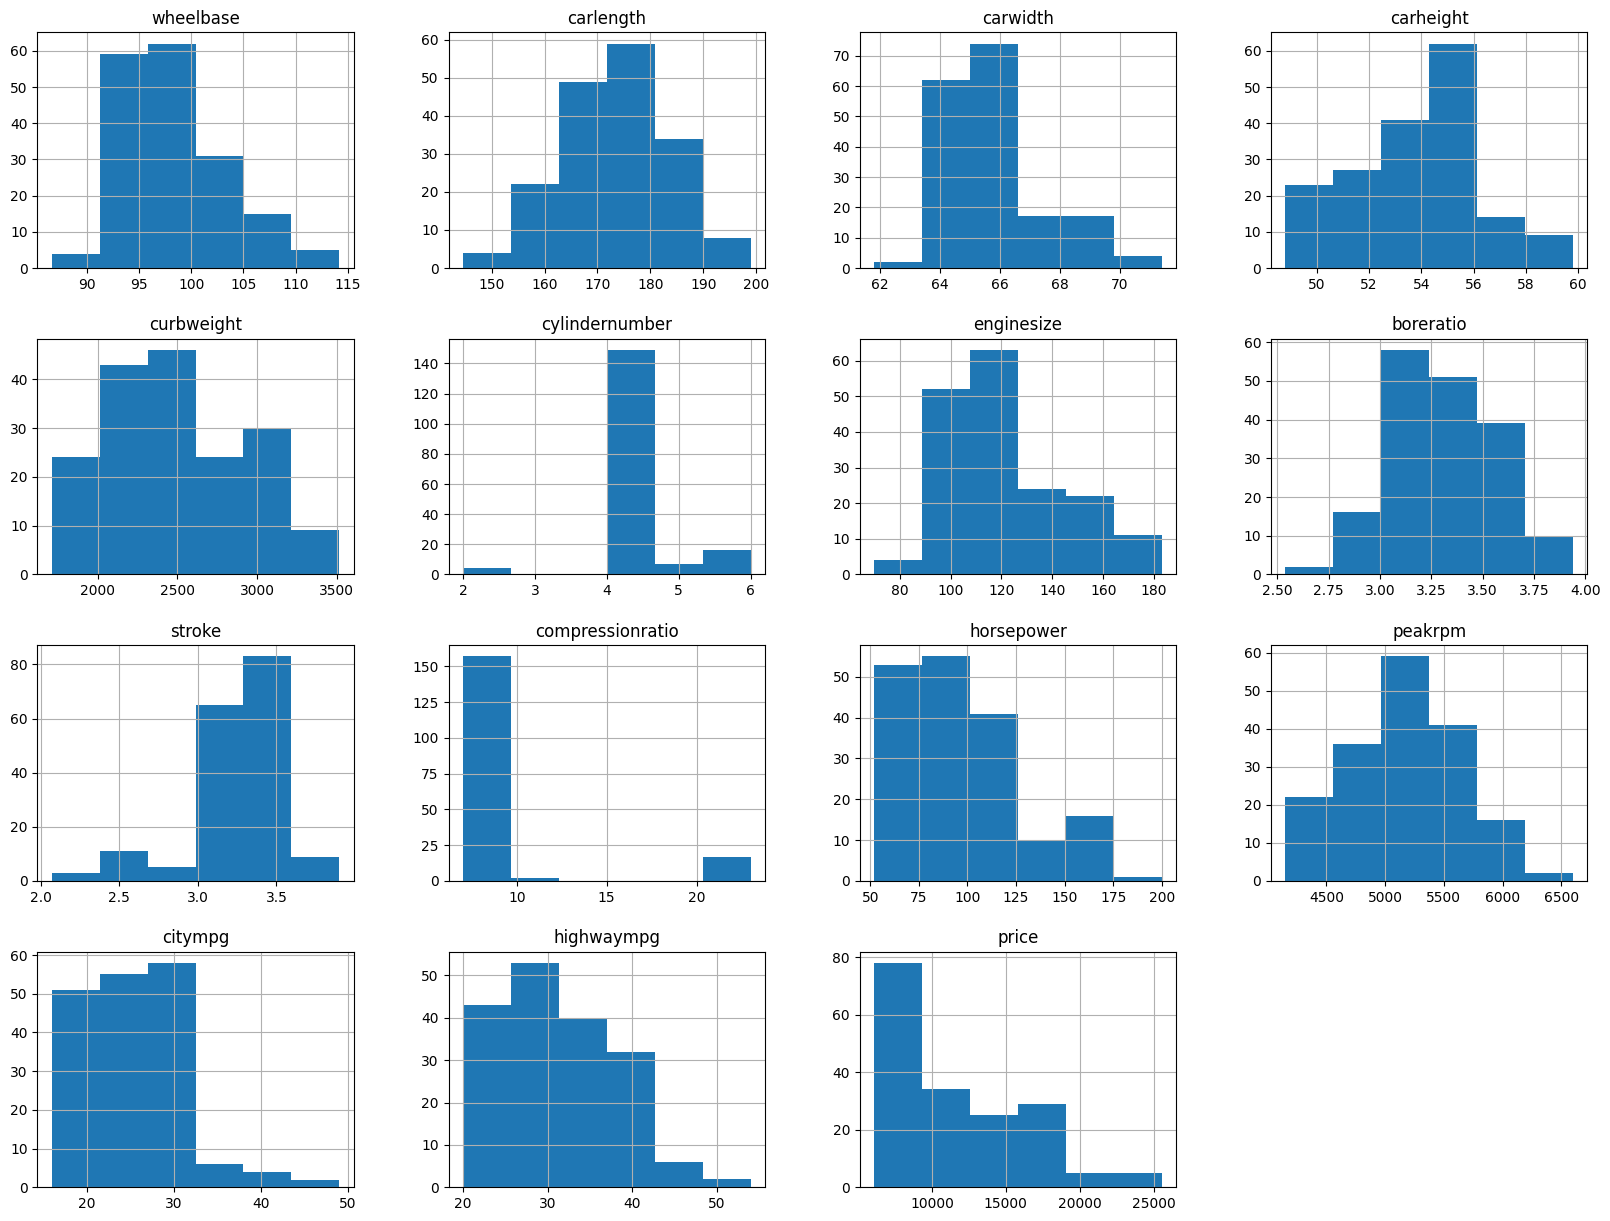

In [13]:
data.to_pandas().hist(bins=6,figsize=(20,15))
plt.show()

Bivariate Analysis

In [14]:
# sns.pairplot(data[num_cols].to_pandas(),y_vars=num_cols)

Feature engineering

In [15]:
num_cols=num_cols+cat_cols

<AxesSubplot: >

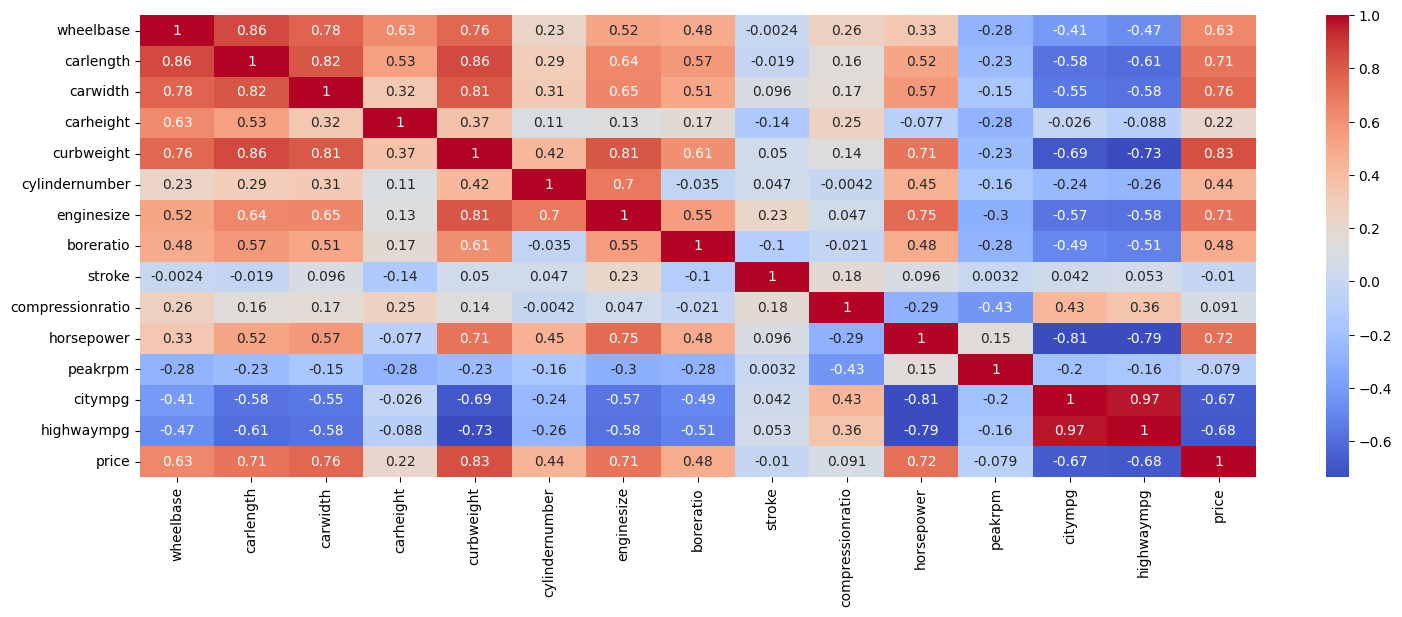

In [16]:
plt.figure(figsize=(18,6))
sns.heatmap(data.to_pandas().corr(),annot=True,cmap="coolwarm",robust=True)

In [17]:
corr=data.corr()[-1].transpose(include_header=True,column_names=["corr"])
corr=corr.with_columns(np.abs(corr["corr"])).sort(by="corr",descending=True)
drop=corr.filter(corr["corr"]<0.6)
drop

column,corr
str,f64
"""boreratio""",0.4793
"""cylindernumber…",0.441781
"""carheight""",0.216169
"""compressionrat…",0.091074
"""peakrpm""",0.078672
"""stroke""",0.010129


In [18]:
corr.filter(corr["corr"]>0.6)

column,corr
str,f64
"""price""",1.0
"""curbweight""",0.830636
"""carwidth""",0.761508
"""horsepower""",0.724212
"""enginesize""",0.711791
"""carlength""",0.711586
"""highwaympg""",0.681829
"""citympg""",0.671034
"""wheelbase""",0.634137


In [19]:
num_cols=[col for  col in num_cols if col not in drop["column"]]

In [20]:
data=data.drop(drop["column"].to_list())

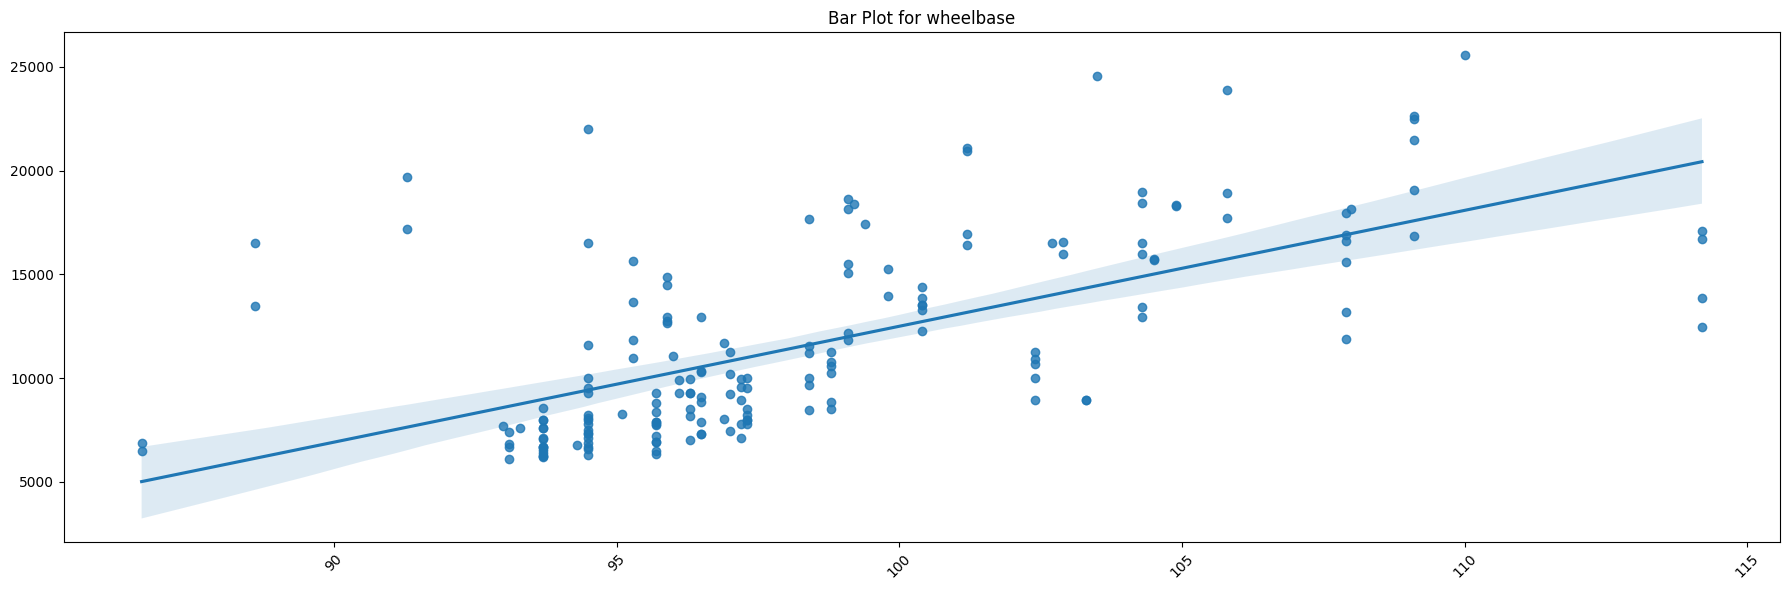

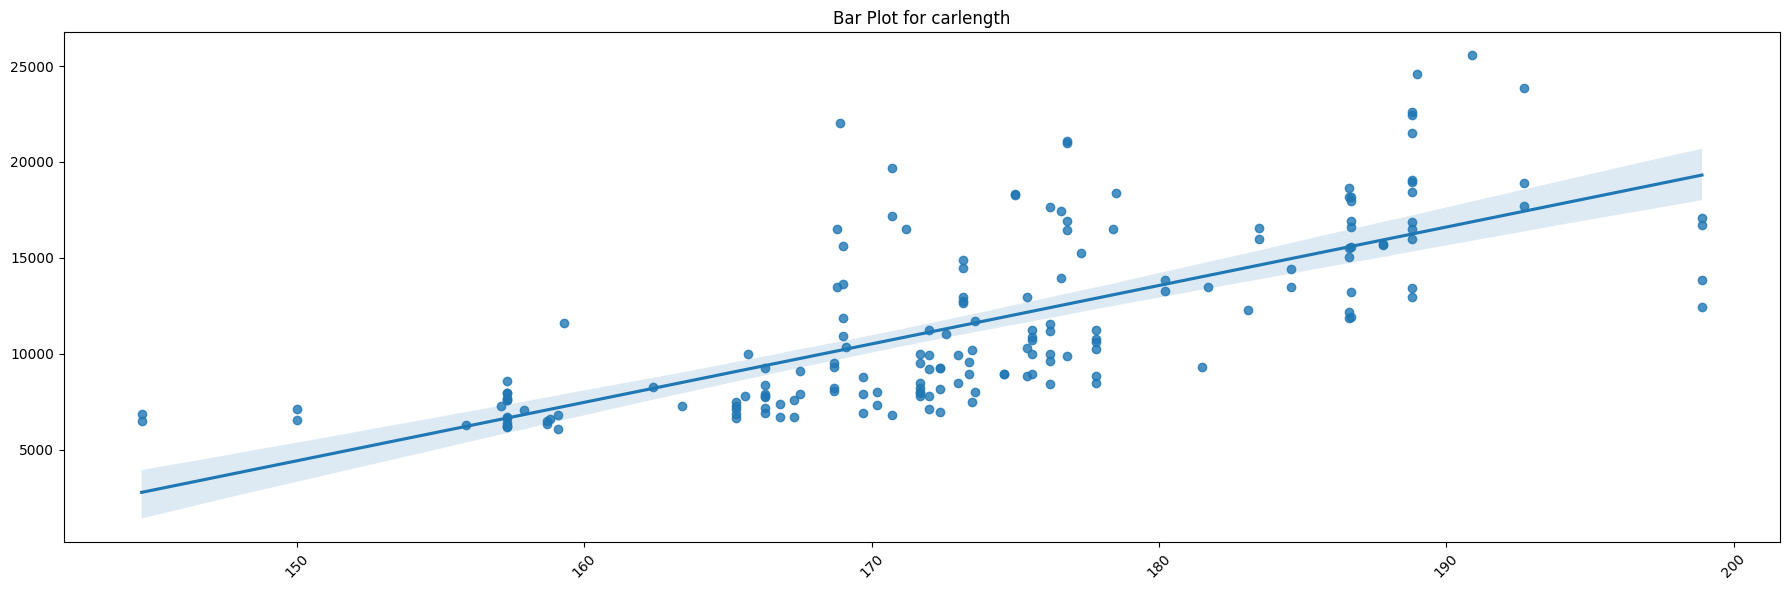

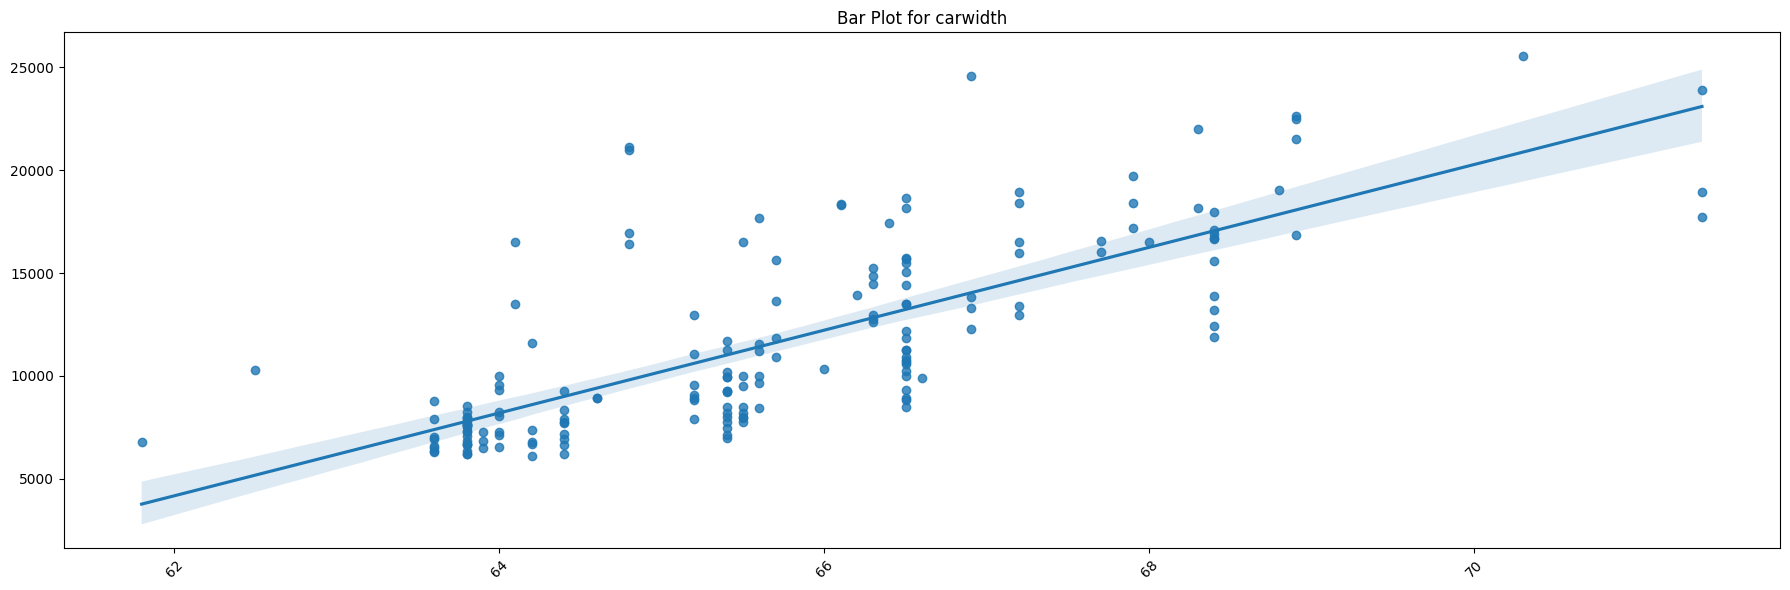

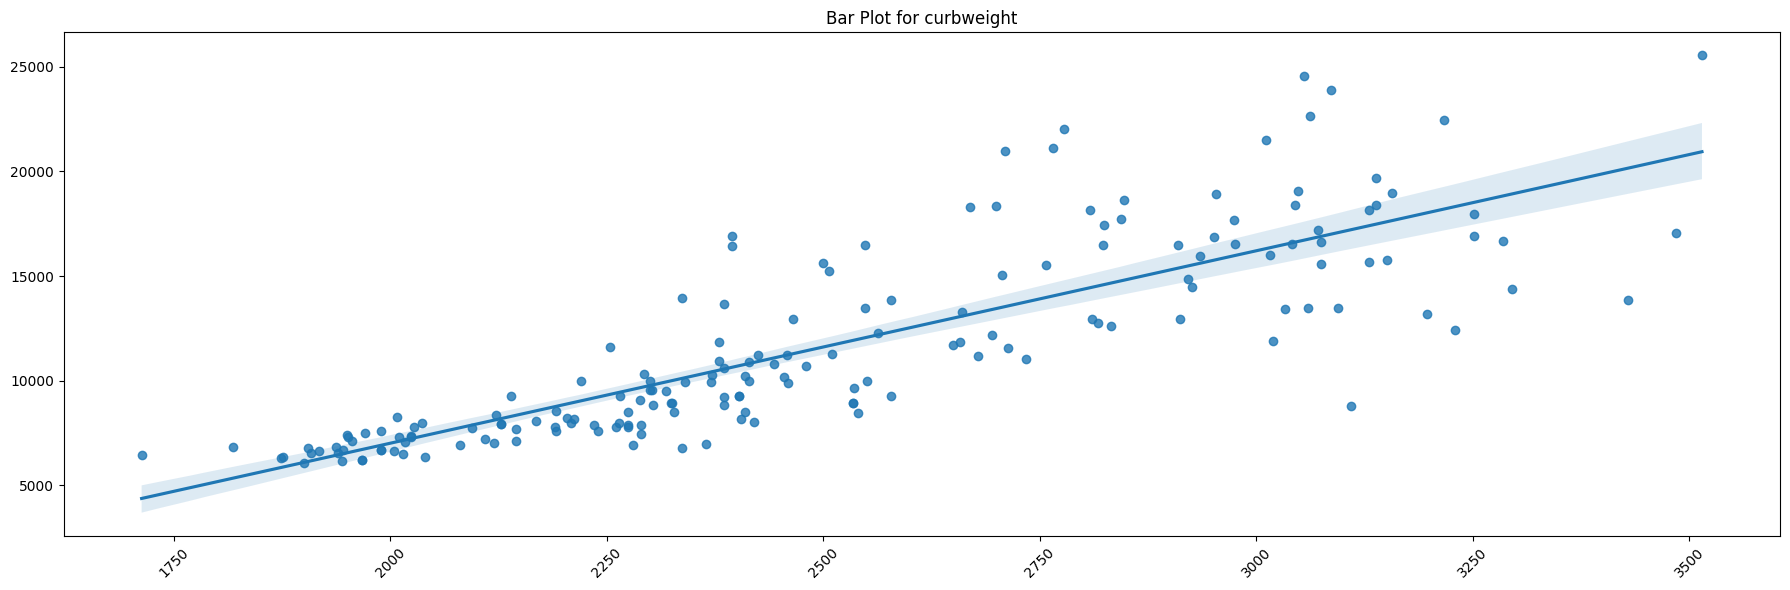

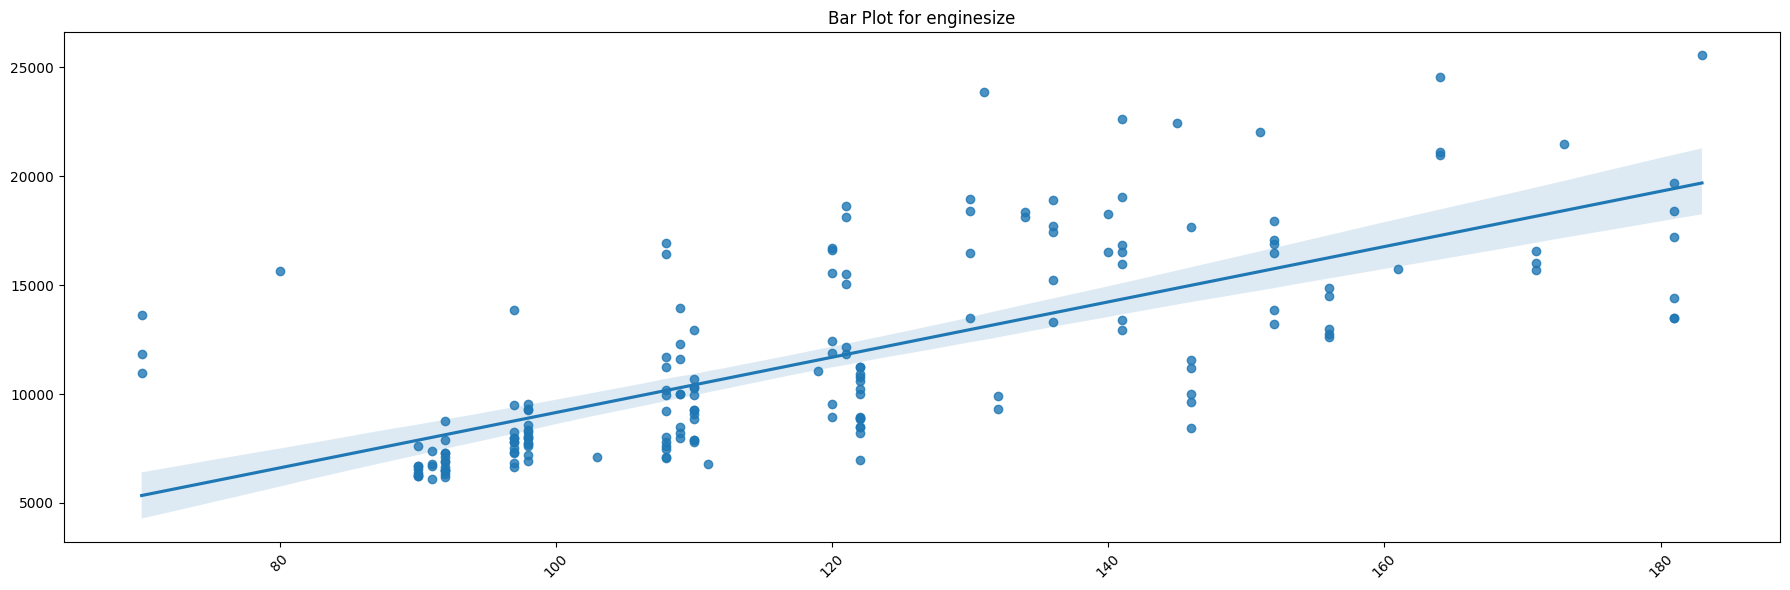

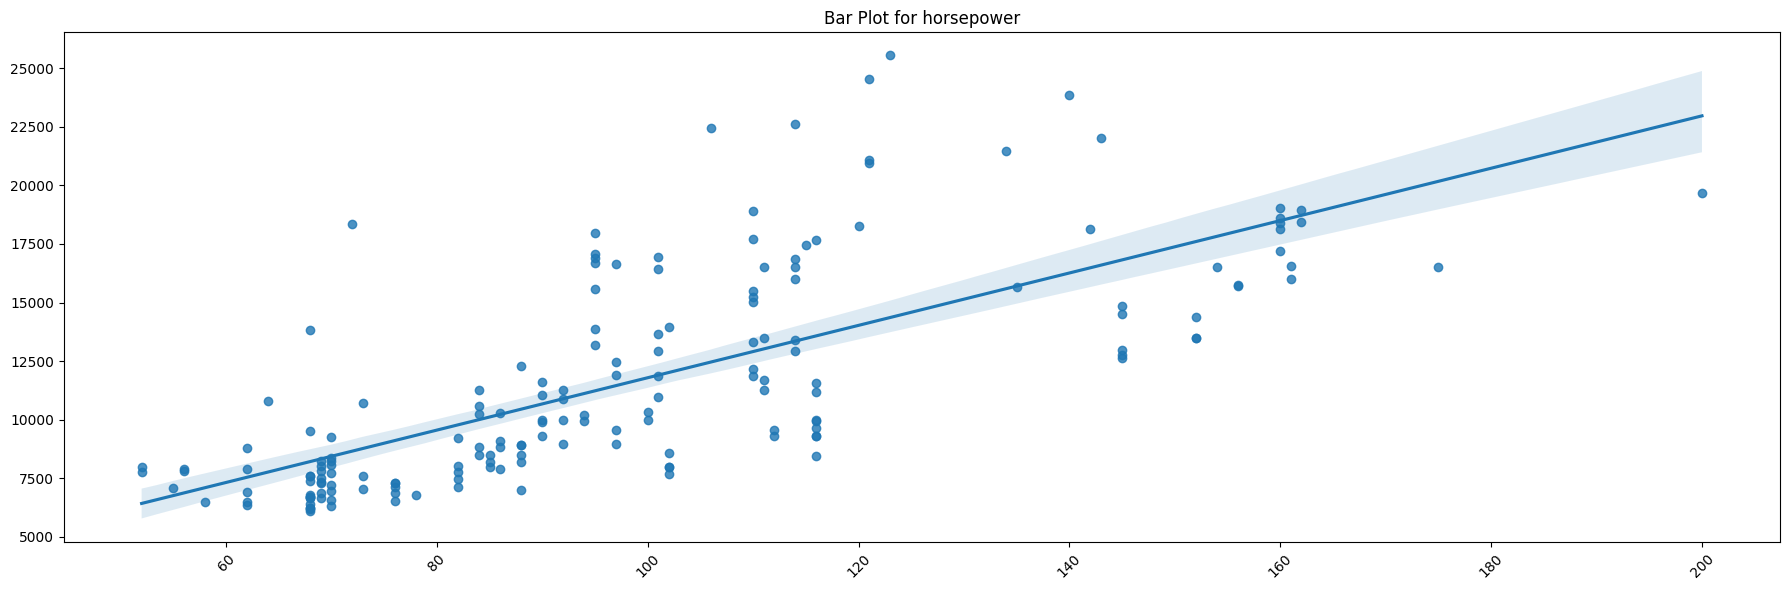

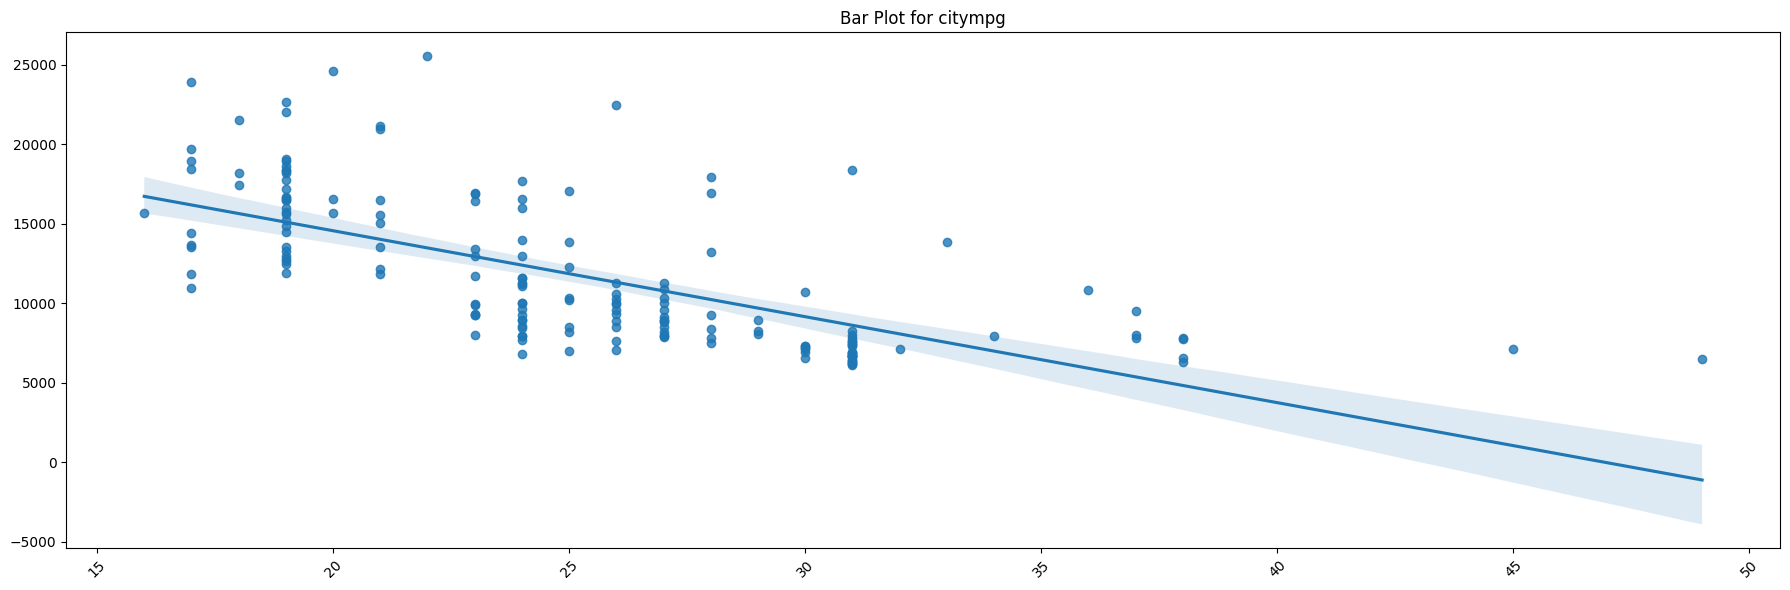

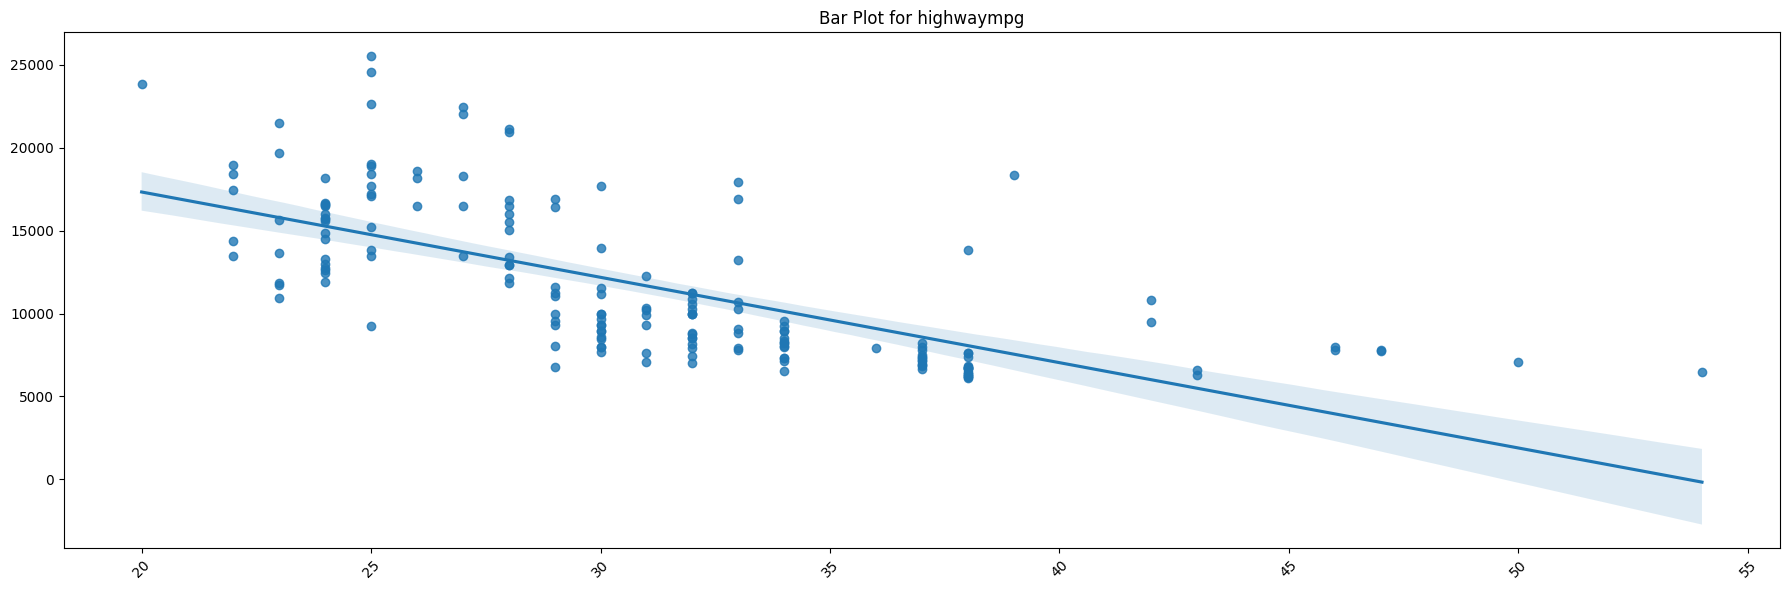

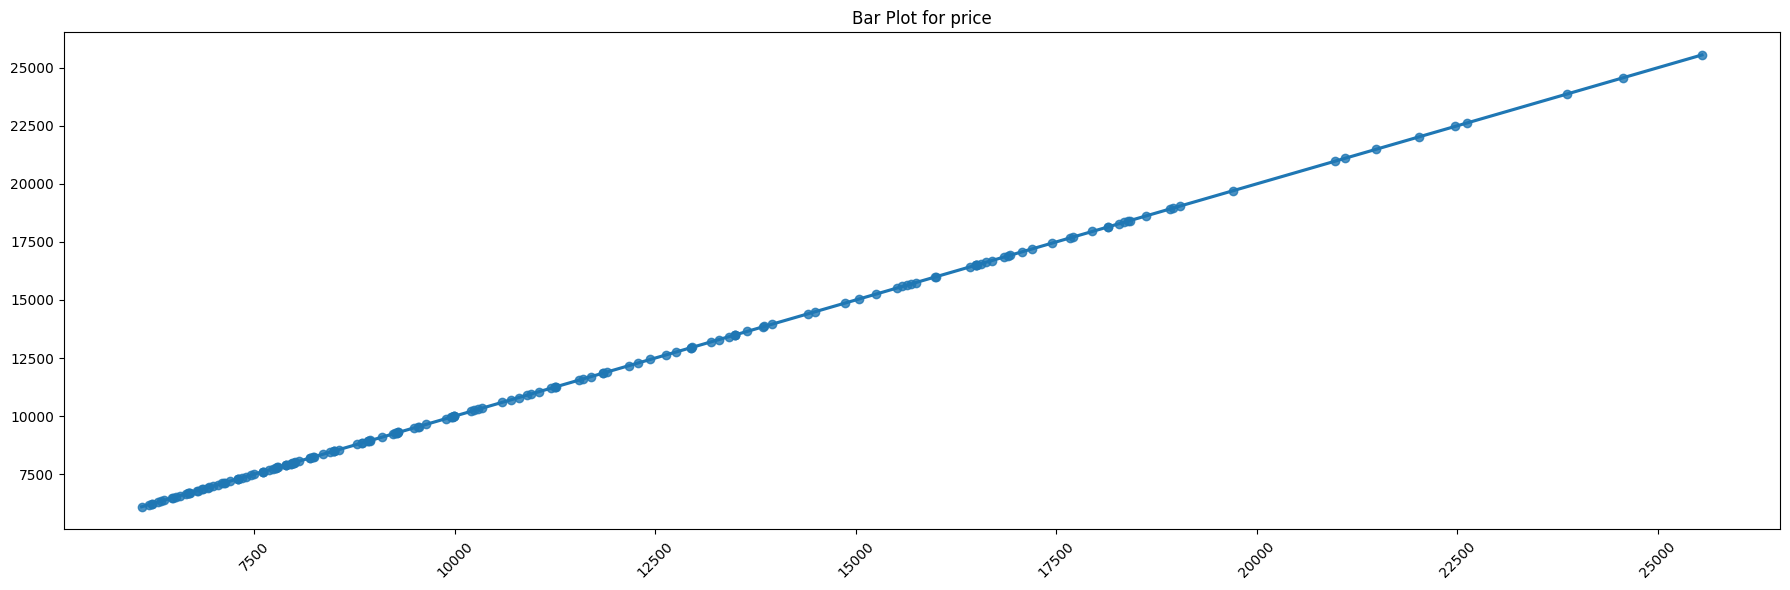

In [21]:
num_scatter_plot(data,num_cols,"price")

We can drop wheel_base,population,households

In [22]:
from sklearn.metrics import r2_score

def get_metrics(X,y_true,y_pred):
    r2 = r2_score(y_true,y_pred)
    adjusted_r2 = 1 - (1-r2)*(len(y_true)-1)/(len(y_true)-X.shape[1]-1)
    return r2,adjusted_r2

In [23]:
from sklearn.model_selection import train_test_split
X = data.drop(['price']).to_pandas()
y = data['price'].to_pandas()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

Training without Managing multicollinear features

In [24]:
from statsmodels.api import OLS
ols=OLS(y_train,X_train).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              345.2
Date:                Sat, 18 May 2024   Prob (F-statistic):                    1.26e-76
Time:                        15:24:40   Log-Likelihood:                         -1141.6
No. Observations:                 123   AIC:                                      2299.
Df Residuals:                     115   BIC:                                      2322.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
wheelbase    150.7457    103.673      1.454      0.149     -54.611     356.102
carlength    -80.3263     57.899     -1.387      0.168    -195.014      34.361
carwidth     -42.7672    154.552     -0.277      0.782    -348.905     263.371
curbweight     6.1123      1.624      3.763      0.000       2.895       9.330
enginesize    14.6245     19.713      0.742      0.460     -24.424      53.673
horsepower    13.8006     20.252      0.681      0.497     -26.315      53.917
citympg     -336.4075    189.989     -1.771      0.079    -712.740      39.925
highwaympg   122.1717    172.231      0.709      0.480    -218.984     463.327
==============================================================================
Omnibus:                       11.289   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.668
Skew:                           0.670   Prob(JB):                      0.00293
Kurtosis:                       3.692   Cond. No.                     2.71e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
y_pred = ols.predict(X_test)
get_metrics(X_test,y_test,y_pred)

(0.7500944352397715, 0.7046570598288209)

Got poor adjusted R2 score

Selecting Features based on correlation top 3

In [26]:
from statsmodels.api import OLS
X_train =X_train[["curbweight","carwidth","horsepower"]]
X_test =X_test[["curbweight","carwidth","horsepower"]]
ols=OLS(y_train,X_train).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              889.2
Date:                Sat, 18 May 2024   Prob (F-statistic):                    9.38e-82
Time:                        15:24:42   Log-Likelihood:                         -1146.1
No. Observations:                 123   AIC:                                      2298.
Df Residuals:                     120   BIC:                                      2307.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
curbweight     7.2553      0.877      8.275      0.000       5.519       8.991
carwidth    -159.4701     26.739     -5.964      0.000    -212.411    -106.530
horsepower    41.5355     11.632      3.571      0.001      18.505      64.566
==============================================================================
Omnibus:                       16.431   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.836
Skew:                           0.837   Prob(JB):                     8.12e-05
Kurtosis:                       3.935   Cond. No.                         283.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
from sklearn.metrics import r2_score
y_pred = ols.predict(X_test)
get_metrics(X_test, y_test, y_pred)

(0.8028061297347415, 0.7907330356368686)

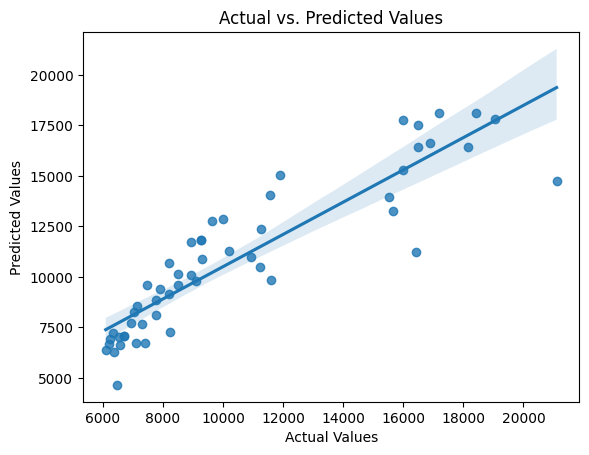

In [28]:
sns.regplot(x=y_test,y=y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

cat_cols=[col for col in data.columns if data[col].dtype== pl.String]
num_cols=[col for col in data.drop("price").columns if data[col].dtype!= pl.String]
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    # ('model', LinearRegression())
])

In [30]:
pipe

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler())]))])

In [31]:
X_scaled=pipe.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3,random_state=42)

In [32]:
ols=OLS(y,X).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                              536.9
Date:                Sat, 18 May 2024   Prob (F-statistic):                   2.13e-115
Time:                        15:24:44   Log-Likelihood:                         -1621.4
No. Observations:                 176   AIC:                                      3259.
Df Residuals:                     168   BIC:                                      3284.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
wheelbase    123.0826     81.775      1.505      0.134     -38.356     284.521
carlength    -55.0321     44.794     -1.229      0.221    -143.464      33.400
carwidth    -150.3980    119.535     -1.258      0.210    -386.382      85.586
curbweight     6.8901      1.325      5.199      0.000       4.274       9.506
enginesize     3.1418     14.549      0.216      0.829     -25.581      31.865
horsepower    32.6392     14.197      2.299      0.023       4.613      60.666
citympg     -234.0606    148.443     -1.577      0.117    -527.115      58.994
highwaympg   131.2745    140.664      0.933      0.352    -146.423     408.972
==============================================================================
Omnibus:                       23.933   Durbin-Watson:                   0.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.507
Skew:                           0.830   Prob(JB):                     1.44e-07
Kurtosis:                       4.240   Cond. No.                     2.76e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
y_pred = ols.predict(pipe.fit_transform(X))
r2_score(y, y_pred)

-6.402672329877787

In [34]:
X_scaled=pipe.fit_transform(X[["curbweight","carwidth","horsepower"]])
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3,random_state=42)

In [35]:
ols=OLS(y_train,X_train).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.166
Model:                            OLS   Adj. R-squared (uncentered):              0.146
Method:                 Least Squares   F-statistic:                              7.985
Date:                Sat, 18 May 2024   Prob (F-statistic):                    6.75e-05
Time:                        15:24:46   Log-Likelihood:                         -1328.4
No. Observations:                 123   AIC:                                      2663.
Df Residuals:                     120   BIC:                                      2671.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4383.9746   1991.958      2.201      0.030     440.037    8327.912
x2          1105.0394   1639.656      0.674      0.502   -2141.365    4351.444
x3          -233.1167   1515.553     -0.154      0.878   -3233.806    2767.573
==============================================================================
Omnibus:                        6.623   Durbin-Watson:                   0.134
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                7.479
Skew:                          -0.345   Prob(JB):                       0.0238
Kurtosis:                       3.992   Cond. No.                         3.57
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
y_pred = ols.predict(X_test)
get_metrics(X_test, y_test,y_pred)

(-7.614299263328345, -8.141705340674978)

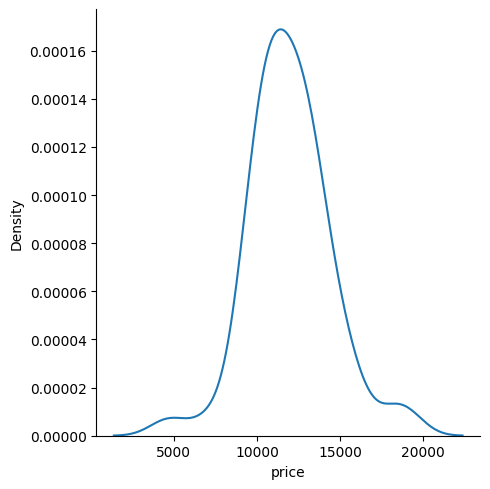

In [37]:
residuals=y_test - y_pred
sns.displot(residuals,kind='kde')

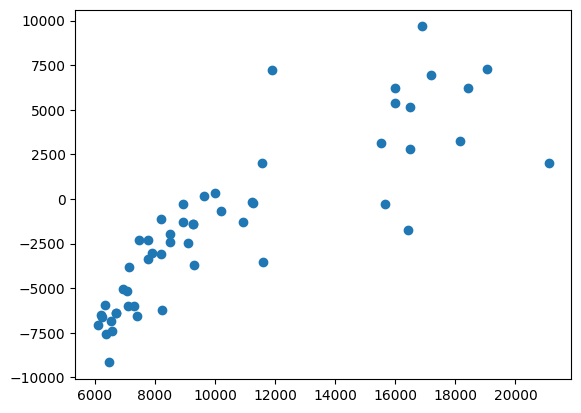

In [38]:
plt.scatter(y_test,y_pred)

Reducing Multicollinearity

In [39]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(data.drop(['price']).to_dummies(columns=cat_cols))

PCA()

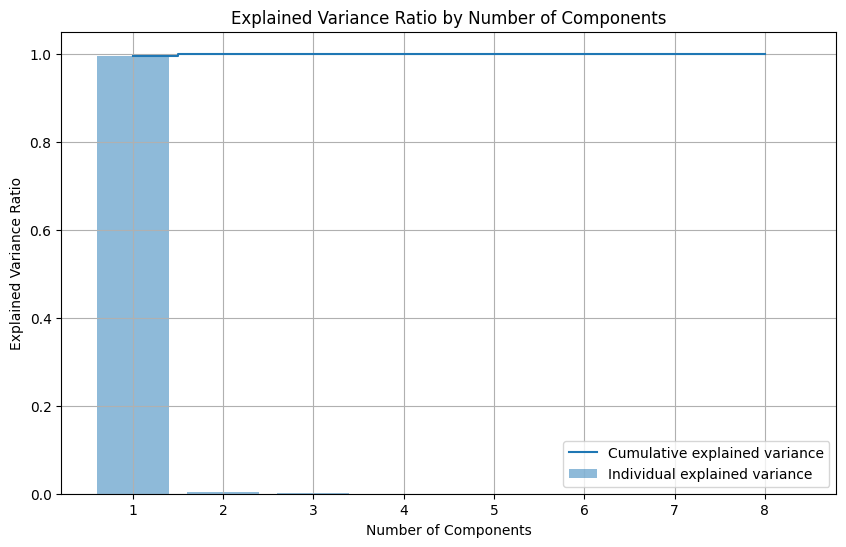

In [40]:
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
     
# Plot explained variance ratio vs. number of components
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Number of Components')
plt.legend(loc='best')
plt.grid()
plt.show()

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
pipe=Pipeline(steps=[
    ("pca",PCA(n_components=3)),
    ("model",LinearRegression())
])

In [42]:
pipe.fit(data.drop(['price']).to_dummies(columns=cat_cols),y)

Pipeline(steps=[('pca', PCA(n_components=3)), ('model', LinearRegression())])

In [43]:
score=[]
for i in range(0,100):
    X_train,X_test,Y_train,Y_test = train_test_split(data.drop(['price']).to_dummies(columns=cat_cols),y,test_size=0.2)
    pipe.fit(X_train,Y_train)
    pred=pipe.predict(X_test)
    score.append(r2_score(Y_test,pred))
print("Average R2 :",np.average(score))

Average R2 : 0.6914597850481659


Average R2: 0.7105940334124918


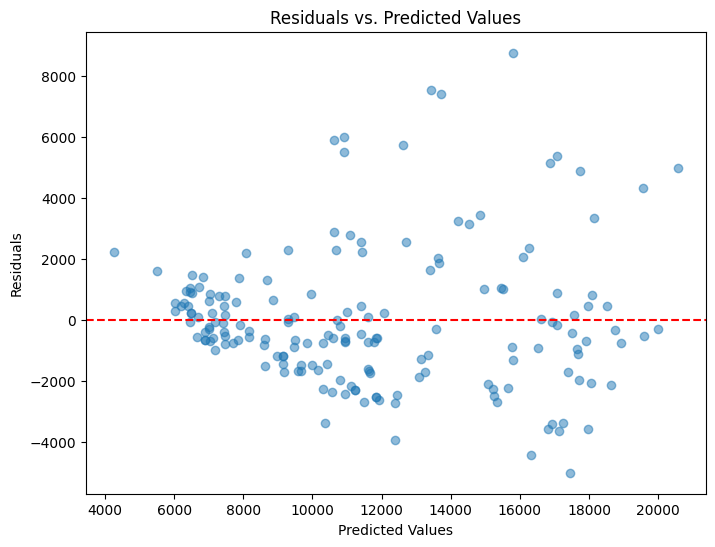

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

# Example pipeline (replace with your actual pipeline)
pipe = Pipeline([('model', LinearRegression())])

# Placeholder for scores
scores = []

for i in range(100):
    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    # Fit the model
    pipe.fit(X_train, Y_train)
    
    # Predict on the test set
    pred = pipe.predict(X_test)
    
    # Calculate R2 score
    r2 = r2_score(Y_test, pred)
    scores.append(r2)
    
# Average R2 score over 100 runs
print("Average R2:", np.mean(scores))

# Residual analysis
# Fit the model on the entire dataset for residual analysis
pipe.fit(X, y)
y_pred = pipe.predict(X)
residuals = y - y_pred

# Plot residuals vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()



Homoscedasticity violated -> variance of residuals changing across the predicted values

In [45]:
from catboost import CatBoostRegressor
pipe=Pipeline(steps=[
    ("pca",PCA(n_components=3)),
    ("model",CatBoostRegressor(
        colsample_bylevel=0.9,
        learning_rate=0.05,
        n_estimators=300,
        reg_lambda=0.1,
        subsample=0.9,verbose=False
    ))
])

In [46]:
#comparision to tree based model
score=[]
for i in range(0,30):
    X_train,X_test,Y_train,Y_test = train_test_split(data.drop(['price']).to_dummies(columns=cat_cols),y,test_size=0.2)
    pipe.fit(X_train,Y_train)
    pred=pipe.predict(X_test)
    score.append(r2_score(Y_test,pred))
print("Average R2 :",np.average(score))

Average R2 : 0.7128304890965993
